#Astronomy 19 Final Project

Author: April Ewers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import astropy.io.fits
import sep

In [6]:
data = astropy.io.fits.open('./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits')

imgdata = data[1].data

In [9]:
print(imgdata.shape)
print(imgdata.max(), imgdata.min())

(8582, 14339)
nan nan


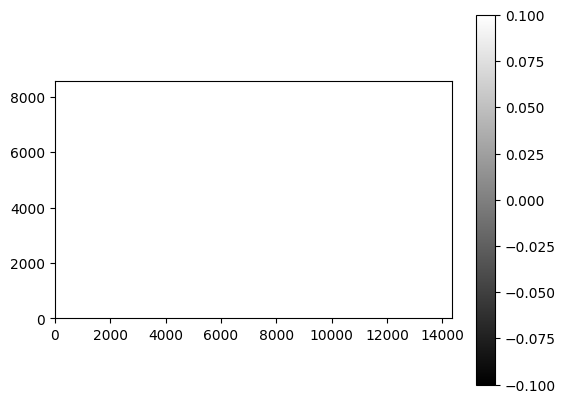

In [7]:
# show the image
m, s = np.mean(imgdata), np.std(imgdata)
plt.imshow(imgdata, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

#save the image
plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d.png', format='png', dpi=300)

In [ ]:
bkg = sep.Background(data)
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('./imgsDemo/jw02731-o001_t017_nircam_clear-f090w_i2d_bkg.png', format='png', dpi=300)

In [ ]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('./imgsDemo/jw02731-o001_t017_nircam_clear-f090w_i2d_noise.png', format='png', dpi=300)